In [ ]:
# 07-11 다층 퍼셉트론(MultiLayer Perceptron, MLP)으로 텍스트 분류하기

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
print(tokenizer.word_index)



{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'count')) # texts_to_matrix의 입력으로 texts를 넣고, 모드는 'count'


[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'binary'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'tfidf').round(3)) # 둘째 자리까지 반올림하여 출력


[[0.    0.    0.847 0.847 1.099 0.    0.    0.    0.    0.   ]
 [0.    0.847 0.847 0.847 0.    0.    0.    0.    0.    0.   ]
 [0.    1.435 0.    0.    0.    1.099 1.099 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.099 1.099 1.099]]


In [ ]:
print(tokenizer.texts_to_matrix(texts, mode = 'freq').round(3)) # 둘째 자리까지 반올림하여 출력


[[0.    0.    0.333 0.333 0.333 0.    0.    0.    0.    0.   ]
 [0.    0.333 0.333 0.333 0.    0.    0.    0.    0.    0.   ]
 [0.    0.5   0.    0.    0.    0.25  0.25  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.333 0.333 0.333]]


In [69]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

newsdata = fetch_20newsgroups(subset = 'train') # 'train'을 기재하면 훈련 데이터만 리턴한다.

print(newsdata.keys())


dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [ ]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))


훈련용 샘플의 개수 : 11314


In [ ]:
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)


총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [ ]:
print('첫번째 샘플의 레이블 : {}'.format(newsdata.target[0]))


첫번째 샘플의 레이블 : 7


In [ ]:
print('7번 레이블이 의미하는 주제 : {}'.format(newsdata.target_names[7]))


7번 레이블이 의미하는 주제 : rec.autos


In [ ]:
print(newsdata.data[0]) # 첫번째 샘플 출력


From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [70]:
data = pd.DataFrame(newsdata.data, columns = ['email'])
data['target'] = pd.Series(newsdata.target)
data[:5]


,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [71]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


In [72]:
data.isnull().values.any()


np.False_

In [73]:
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))


중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


In [74]:
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'plum', 'peru', 'lightcoral']

<Axes: xlabel='target'>

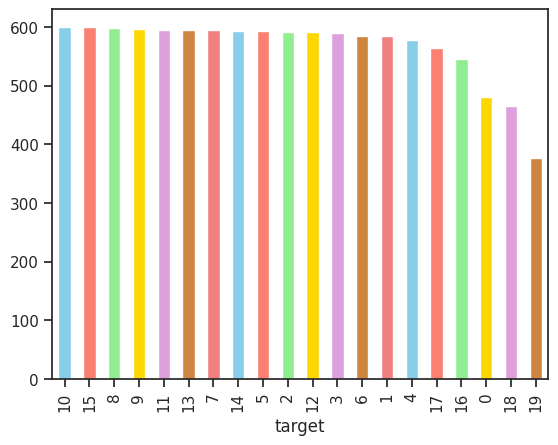

In [75]:

data['target'].value_counts().plot(kind='bar', color=colors[:len(data['target'].value_counts())])

In [76]:
print(data.groupby('target').size().reset_index(name='count'))


    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [77]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
train_email = data['email']
train_label = data['target']
test_email = newsdata_test.data
test_label = newsdata_test.target


In [102]:
vocab_size = 10000
num_classes = 20


In [84]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
    tokenizer.fit_on_texts(train_data)
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    return X_train, X_test, tokenizer.index_word


In [103]:
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))


훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [80]:
print(index_to_word)

Output hidden; open in https://colab.research.google.com to view.

In [82]:
print(y_train[:5])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]


In [87]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.2257 - loss: 2.6270 - val_accuracy: 0.8551 - val_loss: 0.7941
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.7931 - loss: 0.8148 - val_accuracy: 0.9081 - val_loss: 0.3843
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.9228 - loss: 0.3411 - val_accuracy: 0.9187 - val_loss: 0.3005
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9570 - loss: 0.1923 - val_accuracy: 0.9231 - val_loss: 0.2774
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9740 - loss: 0.1217 - val_accuracy: 0.9293 - val_loss: 0.2694
binary 모드의 테스트 정확도: 0.8437334299087524
Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.1700 - loss: 3.0086 - val_accuracy: 0.7871 - val_loss: 1.3879
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.6552 - loss: 1.4396 - val_accuracy: 0.8613 - val_loss: 0.6003
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8435 

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def fit_and_evaluate(X_train, y_train, X_test, y_test, dropout):
  model = Sequential()
  model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
  score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
  return score[1]

modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.
score_result = []
for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
  X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
  for dropout in [0.2,0.3,0.4,0.5]:
    score = fit_and_evaluate(X_train, y_train, X_test, y_test, dropout) # 모델을 훈련하고 평가.
    print(mode+' 모드,dropout=',dropout,'의 테스트 정확도:', score)

    # 각 조합의 결과를 딕셔너리 형태로 저장합니다.
    score_result.append({
        'Mode': mode,
        'Dropout': dropout,
        'Score': np.round(score, 4)
    })


# 리스트에 저장된 딕셔너리들을 바탕으로 DataFrame을 생성합니다.
df = pd.DataFrame(score_result)
print(df)


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.4264 - loss: 2.1690 - val_accuracy: 0.9019 - val_loss: 0.4417
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9485 - loss: 0.2499 - val_accuracy: 0.9178 - val_loss: 0.3144
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9883 - loss: 0.0852 - val_accuracy: 0.9284 - val_loss: 0.2630
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9976 - loss: 0.0312 - val_accuracy: 0.9258 - val_loss: 0.2748
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9980 - loss: 0.0209 - val_accuracy: 0.9267 - val_loss: 0.2789
binary 모드,dropout= 0.2 의 테스트 정확도: 0.8202336430549622
Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.3720 - loss: 2.3092 - val_accuracy: 0.8984 - val_loss: 0.4967
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9252 - loss: 0.3495 - val_accuracy: 0.9187 - val_loss: 0.3123
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accu

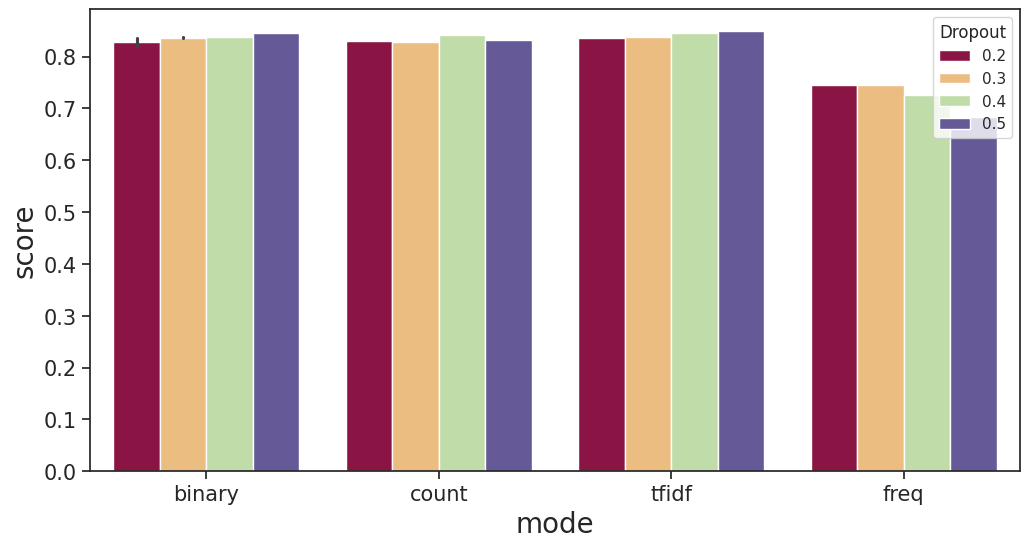

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='Mode', y='Score',hue='Dropout', data=df, palette='Spectral')
#plt.title('modedropout',size=20)

plt.xticks(size=15)
plt.yticks(size=15)

plt.xlabel('mode', size=20)
plt.ylabel('score', size=20)

plt.show()

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def fit_and_evaluate(X_train, y_train, X_test, y_test, dropout):
  model = Sequential()
  model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
  score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
  return score[1]

modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.
score_result = []
for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
  X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
  for dropout in [0.2,0.3,0.4,0.5]:
    score = fit_and_evaluate(X_train, y_train, X_test, y_test, dropout) # 모델을 훈련하고 평가.
    print(mode+' 모드,dropout=',dropout,'의 테스트 정확도:', score)

    # 각 조합의 결과를 딕셔너리 형태로 저장합니다.
    score_result.append({
        'Mode': mode,
        'Dropout': dropout,
        'Score': np.round(score, 4)
    })


# 리스트에 저장된 딕셔너리들을 바탕으로 DataFrame을 생성합니다.
df = pd.DataFrame(score_result)
print(df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3811 - loss: 2.2513 - val_accuracy: 0.8781 - val_loss: 0.5310
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9268 - loss: 0.3474 - val_accuracy: 0.9037 - val_loss: 0.3628
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9776 - loss: 0.1263 - val_accuracy: 0.9064 - val_loss: 0.3219
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9920 - loss: 0.0594 - val_accuracy: 0.9037 - val_loss: 0.3245
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9967 - loss: 0.0313 - val_accuracy: 0.9143 - val_loss: 0.3111
binary 모드,dropout= 0.2 의 테스트 정확도: 0.821561336517334
Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3263 - loss: 2.3779 - val_accuracy: 0.8631 - val_loss: 0.5874
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.8867 - loss: 0.4775 - val_accuracy: 0.9011 - val_loss: 0.3699
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.96

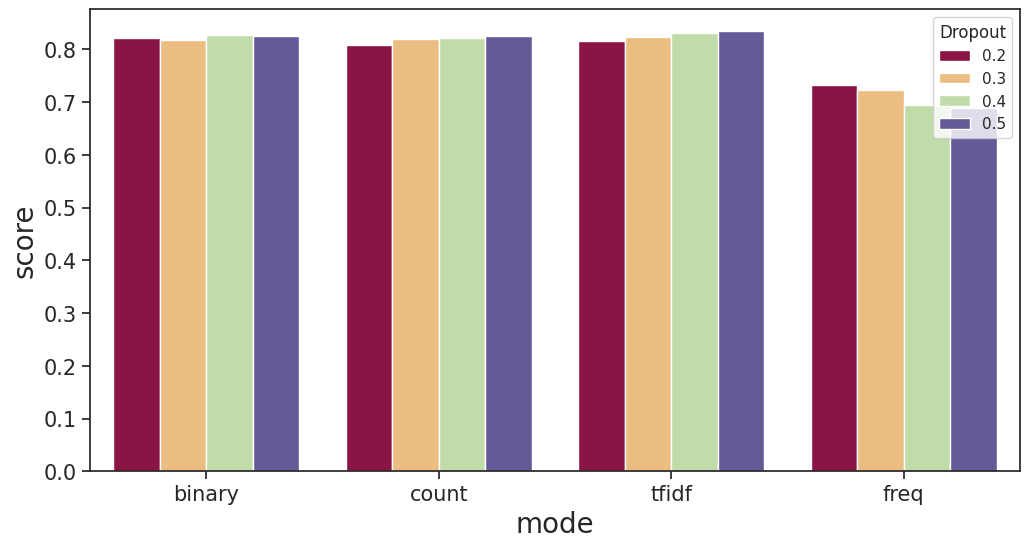

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='Mode', y='Score',hue='Dropout', data=df, palette='Spectral')
#plt.title('modedropout',size=20)

plt.xticks(size=15)
plt.yticks(size=15)

plt.xlabel('mode', size=20)
plt.ylabel('score', size=20)

plt.show()